In [1]:
import os
import cv2
from random import random
import time
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow

In [2]:
#initialize google earth engine
import ee
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6kjqAY-o5GmrlYpvYsgo2DuVw88QoFrv_vmpQjMXJQY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4O7nxuOpoxfQD-rAJtLx1Vk2QgUBVbF3IfvolhAy5QLdlLDCRGFJY

Successfully saved authorization token.


### Helper functions

In [7]:
def getMetaData(radius):
  radius = radius/1000 
  square_side = radius*2
  print("Area:{:.2f} sq KM".format((square_side*square_side)))
  print("Perimeter:{:.2f} KM".format((square_side*4)))
  print("Square Side:{:.2f} KM".format(square_side))

In [3]:
# Visualize ROI (Region of interest) -- Works for Landsat; Issue with Sentinal

def plotROI(image,roi,save = False, debug = False ):
  
  date = image.date().format('YYYY-MM-dd').getInfo()
  if debug: print('Timestamp: ', date);
  url = image.getThumbURL({
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.5,
  'gamma': [0.95, 1.1, 1],
  'region': roi

  })
  fname = "RGB_"+str(date)+str(random()).split('.')[1]+".png"

  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug: 
      print("File name:", fname)
      img = cv2.imread(fname)
      cv2_imshow(img)
    if not save: 
      os.remove(fname)
      return date, "NaN"
  return date, fname

In [46]:
# download data locally

def downloadROI(image,roi,bands,debug = False ):
  
  date = image.date().format('YYYY-MM-dd').getInfo()
  if debug: print('Timestamp: ', date);
  url = image.getDownloadUrl({
  'bands': bands,
  'min': 0,
  'max': 0.5,
  'gamma': [0.95, 1.1, 1],
  'crs': 'EPSG:4326',
  'scale':10,
  'region': roi

  })
  fname = str(date)+"_"+str(random()).split('.')[1]+".zip"
  if debug: print("Downloading:",url)

  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug: 
      print("File name:", fname)

  return date, fname

### Inputs 

In [134]:

#Enter longitude and latitude
latitude,longitude  = 13.538461, -14.760164

#Enter radius in meters
radius = 5000  
###

#generate polygon shape from latitude and longitude. 
#can replace with any geomentry shapes like rectangle, multipolygon...
#more info to create geomentry are available in https://developers.google.com/earth-engine/apidocs/ee-geometry?hl=en 
roi = ee.Geometry.Point([longitude, latitude]).buffer(radius).bounds()

#Info on region of interest
getMetaData(radius)


Area:100.00 sq KM
Perimeter:40.00 KM
Square Side:10.00 KM


### Filter Data

In [135]:
# collecting data from landsat- https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA?hl=en

#filtering the images in the chosen image collection
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
    .filterBounds(roi) \
    .filterMetadata('CLOUD_COVER', 'less_than', 5)\
    .filterDate('2020-01-01', '2020-09-01')

totalImages = collection.size().getInfo()
print("Total count of images in the collection:",totalImages)


Total count of images: 16


Image Info 
 {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 'crs': 'EPSG:32628', 'crs_transform': [30, 0, 376485, 0, -30, 1714215]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 'crs': 'EPSG:32628', 'crs_transform': [30, 0, 376485, 0, -30, 1714215]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 'crs': 'EPSG:32628', 'crs_transform': [30, 0, 376485, 0, -30, 1714215]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 'crs': 'EPSG:32628', 'crs_transform': [30, 0, 376485, 0, -30, 1714215]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 'crs': 'EPSG:32628', 'crs_transform': [30, 0, 376485, 0, -30, 1714215]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7591, 7761], 

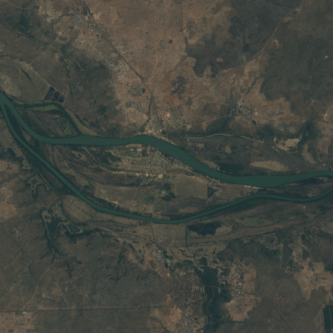

('2020-01-31', 'NaN')

In [137]:
#Visualize first image in the image collection
image = ee.Image(collection.toList(collection.size()).get(0)) # 0 --> first image
print("Image Info \n",image.getInfo())

#Works for Landsat; Issue with Sentinal
plotROI(image,roi,save=False,debug=True)

### Download data locally

In [108]:
bands = ['B4', 'B3', 'B2'] #band info are available in https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA?hl=en

for idx in range(totalImages):
  print("Downloading {} of {}".format(idx+1,totalImages))
  image = ee.Image(collection.toList(collection.size()).get(idx))
  date, fname = downloadROI(image,roi,bands,debug = False)
  print("Downloaded:",fname)

Downloaded: 2020-01-06_023523590939832473.zip
Downloaded: 2020-02-07_6443196015151178.zip
Downloaded: 2020-03-10_2863285730126297.zip
Downloaded: 2020-03-26_250210933434428.zip
Downloaded: 2020-04-11_5420810881426439.zip
Downloaded: 2020-04-27_5356030962160134.zip
Downloaded: 2020-05-13_5617568523263602.zip
Downloaded: 2020-05-29_3334170173352087.zip


### Export to Drive

In [177]:
#Exporting Images from Sentinal - https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR?hl=en
collection = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate('2020-01-01', '2020-09-01')\
    .filterBounds(roi) \
    .select(['B4', 'B3', 'B2']) 

totalImages = collection.size().getInfo()
print("Total count of images:",totalImages)



Total count of images: 98


In [ ]:
#exporting only the first image

image = ee.Image(collection.toList(collection.size()).get(0))

"""
description - file name to be stored as
scale - Resolution in meters per pixel. Defaults to 1000.
folder - folder name to create/save in drive  
crs - coordinate reference system value (optional)
"""
task = ee.batch.Export.image.toDrive(**{
    'image': image,
    'description': 'senegal',
    'folder':'GEE_folder',
    'scale': 10,
    'crs': 'EPSG:4326',
    'region': roi
})

# job will be running in the GEE 
task.start()

#uncomment the while loop if you want to wait till the task complete
"""
while task.active():
  print('Processing...')
  time.sleep(10)

task.status()
"""

In [181]:
#to check the status of the task. 
#It will take long time to complete.
task.status()

{'attempt': 1,
 'creation_timestamp_ms': 1607180550295,
 'description': 'senegal',
 'destination_uris': ['https://drive.google.com/#folders/1Te0wcE-iL--YhS0qr5zDIUr_Gbllntod'],
 'id': '6ZTBEP73Z62CQT65EP3NWNWD',
 'name': 'projects/earthengine-legacy/operations/6ZTBEP73Z62CQT65EP3NWNWD',
 'start_timestamp_ms': 1607180570291,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1607180596693}